##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0-rc1
Hub version: 0.12.0
GPU is available


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [3]:
#@title

model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 0s

  7651328/228813984 [>.............................] - ETA: 1s

 18939904/228813984 [=>............................] - ETA: 1s

 31875072/228813984 [===>..........................] - ETA: 0s

 46088192/228813984 [=====>........................] - ETA: 0s

 58851328/228813984 [======>.......................] - ETA: 0s

 72155136/228813984 [========>.....................] - ETA: 0s

 86056960/228813984 [==========>...................] - ETA: 0s

 99287040/228813984 [============>.................] - ETA: 0s

112648192/228813984 [=============>................] - ETA: 0s

126500864/228813984 [===============>..............] - ETA: 0s

141115392/228813984 [=================>............] - ETA: 0s

155893760/228813984 [===================>..........] - ETA: 0s

169484288/228813984 [=====================>........] - ETA: 0s

183009280/228813984 [======================>.......] - ETA: 0s

196681728/228813984 [========================>.....] - ETA: 0s

209993728/228813984 [==========================>...] - ETA: 0s

224485376/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


Found 3670 files belonging to 5 classes.


Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 1280)              207615832 


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 5)                 6405      


Total params: 207,622,237


Trainable params: 6,405


Non-trainable params: 207,615,832


_________________________________________________________________


## Training the model

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


  1/183 [..............................] - ETA: 1:35:00 - loss: 2.3761 - accuracy: 0.2500

  2/183 [..............................] - ETA: 1:58 - loss: 2.2212 - accuracy: 0.3125   

  3/183 [..............................] - ETA: 1:57 - loss: 2.0652 - accuracy: 0.3542

  4/183 [..............................] - ETA: 1:56 - loss: 2.0491 - accuracy: 0.3750

  5/183 [..............................] - ETA: 1:56 - loss: 1.9770 - accuracy: 0.3875

  6/183 [..............................] - ETA: 1:55 - loss: 1.8384 - accuracy: 0.4271

  7/183 [>.............................] - ETA: 1:55 - loss: 1.7222 - accuracy: 0.4821

  8/183 [>.............................] - ETA: 1:54 - loss: 1.6384 - accuracy: 0.5234

  9/183 [>.............................] - ETA: 1:53 - loss: 1.6042 - accuracy: 0.5347

 10/183 [>.............................] - ETA: 1:53 - loss: 1.5286 - accuracy: 0.5688

 11/183 [>.............................] - ETA: 1:52 - loss: 1.4796 - accuracy: 0.5909

 12/183 [>.............................] - ETA: 1:51 - loss: 1.4416 - accuracy: 0.6198

 13/183 [=>............................] - ETA: 1:51 - loss: 1.3980 - accuracy: 0.6394

 14/183 [=>............................] - ETA: 1:50 - loss: 1.3703 - accuracy: 0.6607

 15/183 [=>............................] - ETA: 1:49 - loss: 1.3463 - accuracy: 0.6833

 16/183 [=>............................] - ETA: 1:49 - loss: 1.3241 - accuracy: 0.6992

 17/183 [=>............................] - ETA: 1:48 - loss: 1.3134 - accuracy: 0.7059

 18/183 [=>............................] - ETA: 1:48 - loss: 1.2899 - accuracy: 0.7188

 19/183 [==>...........................] - ETA: 1:47 - loss: 1.2814 - accuracy: 0.7336

 20/183 [==>...........................] - ETA: 1:46 - loss: 1.2669 - accuracy: 0.7406

 21/183 [==>...........................] - ETA: 1:46 - loss: 1.2500 - accuracy: 0.7530

 22/183 [==>...........................] - ETA: 1:45 - loss: 1.2346 - accuracy: 0.7642

 23/183 [==>...........................] - ETA: 1:44 - loss: 1.2498 - accuracy: 0.7663

 24/183 [==>...........................] - ETA: 1:44 - loss: 1.2340 - accuracy: 0.7760

 25/183 [===>..........................] - ETA: 1:43 - loss: 1.2512 - accuracy: 0.7775

 26/183 [===>..........................] - ETA: 1:42 - loss: 1.2381 - accuracy: 0.7861

 27/183 [===>..........................] - ETA: 1:42 - loss: 1.2485 - accuracy: 0.7894

 28/183 [===>..........................] - ETA: 1:41 - loss: 1.2370 - accuracy: 0.7969

 29/183 [===>..........................] - ETA: 1:40 - loss: 1.2287 - accuracy: 0.8017

 30/183 [===>..........................] - ETA: 1:40 - loss: 1.2207 - accuracy: 0.8083

 31/183 [====>.........................] - ETA: 1:39 - loss: 1.2136 - accuracy: 0.8145

 32/183 [====>.........................] - ETA: 1:38 - loss: 1.2047 - accuracy: 0.8203

 33/183 [====>.........................] - ETA: 1:38 - loss: 1.2018 - accuracy: 0.8220

 34/183 [====>.........................] - ETA: 1:37 - loss: 1.2058 - accuracy: 0.8217

 35/183 [====>.........................] - ETA: 1:36 - loss: 1.2067 - accuracy: 0.8214

 36/183 [====>.........................] - ETA: 1:36 - loss: 1.1947 - accuracy: 0.8264

 37/183 [=====>........................] - ETA: 1:35 - loss: 1.1944 - accuracy: 0.8260

 38/183 [=====>........................] - ETA: 1:34 - loss: 1.1921 - accuracy: 0.8273

 39/183 [=====>........................] - ETA: 1:34 - loss: 1.1840 - accuracy: 0.8301

 40/183 [=====>........................] - ETA: 1:33 - loss: 1.1778 - accuracy: 0.8328

 41/183 [=====>........................] - ETA: 1:32 - loss: 1.1666 - accuracy: 0.8369

 42/183 [=====>........................] - ETA: 1:32 - loss: 1.1625 - accuracy: 0.8378

 43/183 [======>.......................] - ETA: 1:31 - loss: 1.1695 - accuracy: 0.8401

 44/183 [======>.......................] - ETA: 1:30 - loss: 1.1633 - accuracy: 0.8409

 45/183 [======>.......................] - ETA: 1:30 - loss: 1.1532 - accuracy: 0.8444

 46/183 [======>.......................] - ETA: 1:29 - loss: 1.1502 - accuracy: 0.8465

 47/183 [======>.......................] - ETA: 1:28 - loss: 1.1536 - accuracy: 0.8457

 48/183 [======>.......................] - ETA: 1:28 - loss: 1.1441 - accuracy: 0.8490

 49/183 [=======>......................] - ETA: 1:27 - loss: 1.1369 - accuracy: 0.8508

 50/183 [=======>......................] - ETA: 1:26 - loss: 1.1288 - accuracy: 0.8525

 51/183 [=======>......................] - ETA: 1:26 - loss: 1.1291 - accuracy: 0.8517

 52/183 [=======>......................] - ETA: 1:25 - loss: 1.1248 - accuracy: 0.8534

 53/183 [=======>......................] - ETA: 1:25 - loss: 1.1150 - accuracy: 0.8561

 54/183 [=======>......................] - ETA: 1:24 - loss: 1.1084 - accuracy: 0.8576

 55/183 [========>.....................] - ETA: 1:23 - loss: 1.0986 - accuracy: 0.8602

 56/183 [========>.....................] - ETA: 1:23 - loss: 1.0913 - accuracy: 0.8627

 57/183 [========>.....................] - ETA: 1:22 - loss: 1.0847 - accuracy: 0.8629

 58/183 [========>.....................] - ETA: 1:21 - loss: 1.0761 - accuracy: 0.8653

 59/183 [========>.....................] - ETA: 1:21 - loss: 1.0699 - accuracy: 0.8665

 60/183 [========>.....................] - ETA: 1:20 - loss: 1.0620 - accuracy: 0.8677

 61/183 [=========>....................] - ETA: 1:19 - loss: 1.0583 - accuracy: 0.8689

 62/183 [=========>....................] - ETA: 1:19 - loss: 1.0566 - accuracy: 0.8679

 63/183 [=========>....................] - ETA: 1:18 - loss: 1.0544 - accuracy: 0.8690

 64/183 [=========>....................] - ETA: 1:17 - loss: 1.0513 - accuracy: 0.8701

 65/183 [=========>....................] - ETA: 1:17 - loss: 1.0508 - accuracy: 0.8692

 66/183 [=========>....................] - ETA: 1:16 - loss: 1.0547 - accuracy: 0.8674

 67/183 [=========>....................] - ETA: 1:15 - loss: 1.0476 - accuracy: 0.8694

 68/183 [==========>...................] - ETA: 1:15 - loss: 1.0424 - accuracy: 0.8704

 69/183 [==========>...................] - ETA: 1:14 - loss: 1.0382 - accuracy: 0.8687

 70/183 [==========>...................] - ETA: 1:13 - loss: 1.0328 - accuracy: 0.8705

 71/183 [==========>...................] - ETA: 1:13 - loss: 1.0295 - accuracy: 0.8715

 72/183 [==========>...................] - ETA: 1:12 - loss: 1.0242 - accuracy: 0.8733

 73/183 [==========>...................] - ETA: 1:11 - loss: 1.0261 - accuracy: 0.8724

 74/183 [===========>..................] - ETA: 1:11 - loss: 1.0245 - accuracy: 0.8725

 75/183 [===========>..................] - ETA: 1:10 - loss: 1.0298 - accuracy: 0.8692

 76/183 [===========>..................] - ETA: 1:09 - loss: 1.0255 - accuracy: 0.8701

 77/183 [===========>..................] - ETA: 1:09 - loss: 1.0225 - accuracy: 0.8693

 78/183 [===========>..................] - ETA: 1:08 - loss: 1.0171 - accuracy: 0.8710

 79/183 [===========>..................] - ETA: 1:08 - loss: 1.0161 - accuracy: 0.8710

 80/183 [============>.................] - ETA: 1:07 - loss: 1.0140 - accuracy: 0.8719

 81/183 [============>.................] - ETA: 1:06 - loss: 1.0119 - accuracy: 0.8719

 82/183 [============>.................] - ETA: 1:06 - loss: 1.0073 - accuracy: 0.8735

 83/183 [============>.................] - ETA: 1:05 - loss: 1.0054 - accuracy: 0.8742

 84/183 [============>.................] - ETA: 1:04 - loss: 1.0035 - accuracy: 0.8750

 85/183 [============>.................] - ETA: 1:04 - loss: 1.0032 - accuracy: 0.8743

 86/183 [=============>................] - ETA: 1:03 - loss: 0.9985 - accuracy: 0.8757

 87/183 [=============>................] - ETA: 1:02 - loss: 0.9945 - accuracy: 0.8772

 88/183 [=============>................] - ETA: 1:02 - loss: 0.9943 - accuracy: 0.8764

 89/183 [=============>................] - ETA: 1:01 - loss: 0.9903 - accuracy: 0.8778

 90/183 [=============>................] - ETA: 1:00 - loss: 0.9914 - accuracy: 0.8764

 91/183 [=============>................] - ETA: 1:00 - loss: 0.9906 - accuracy: 0.8764

 92/183 [==============>...............] - ETA: 59s - loss: 0.9885 - accuracy: 0.8750 

 93/183 [==============>...............] - ETA: 58s - loss: 0.9856 - accuracy: 0.8757

 94/183 [==============>...............] - ETA: 58s - loss: 0.9819 - accuracy: 0.8770

 95/183 [==============>...............] - ETA: 57s - loss: 0.9831 - accuracy: 0.8763

 96/183 [==============>...............] - ETA: 56s - loss: 0.9792 - accuracy: 0.8776

 97/183 [==============>...............] - ETA: 56s - loss: 0.9753 - accuracy: 0.8789

 98/183 [===============>..............] - ETA: 55s - loss: 0.9735 - accuracy: 0.8788

 99/183 [===============>..............] - ETA: 54s - loss: 0.9721 - accuracy: 0.8782

100/183 [===============>..............] - ETA: 54s - loss: 0.9707 - accuracy: 0.8788

101/183 [===============>..............] - ETA: 53s - loss: 0.9671 - accuracy: 0.8793

102/183 [===============>..............] - ETA: 52s - loss: 0.9643 - accuracy: 0.8799

103/183 [===============>..............] - ETA: 52s - loss: 0.9637 - accuracy: 0.8805

104/183 [================>.............] - ETA: 51s - loss: 0.9636 - accuracy: 0.8804

105/183 [================>.............] - ETA: 50s - loss: 0.9635 - accuracy: 0.8810

106/183 [================>.............] - ETA: 50s - loss: 0.9684 - accuracy: 0.8797

107/183 [================>.............] - ETA: 49s - loss: 0.9647 - accuracy: 0.8808

108/183 [================>.............] - ETA: 49s - loss: 0.9628 - accuracy: 0.8814

109/183 [================>.............] - ETA: 48s - loss: 0.9596 - accuracy: 0.8825

110/183 [=================>............] - ETA: 47s - loss: 0.9568 - accuracy: 0.8824

111/183 [=================>............] - ETA: 47s - loss: 0.9554 - accuracy: 0.8823

112/183 [=================>............] - ETA: 46s - loss: 0.9537 - accuracy: 0.8828

113/183 [=================>............] - ETA: 45s - loss: 0.9510 - accuracy: 0.8833

114/183 [=================>............] - ETA: 45s - loss: 0.9486 - accuracy: 0.8838

115/183 [=================>............] - ETA: 44s - loss: 0.9538 - accuracy: 0.8826

116/183 [==================>...........] - ETA: 43s - loss: 0.9505 - accuracy: 0.8836

117/183 [==================>...........] - ETA: 43s - loss: 0.9474 - accuracy: 0.8841

118/183 [==================>...........] - ETA: 42s - loss: 0.9447 - accuracy: 0.8851

119/183 [==================>...........] - ETA: 41s - loss: 0.9415 - accuracy: 0.8860

120/183 [==================>...........] - ETA: 41s - loss: 0.9392 - accuracy: 0.8865

121/183 [==================>...........] - ETA: 40s - loss: 0.9366 - accuracy: 0.8864

122/183 [===================>..........] - ETA: 39s - loss: 0.9345 - accuracy: 0.8873

123/183 [===================>..........] - ETA: 39s - loss: 0.9326 - accuracy: 0.8877

124/183 [===================>..........] - ETA: 38s - loss: 0.9295 - accuracy: 0.8886

125/183 [===================>..........] - ETA: 37s - loss: 0.9269 - accuracy: 0.8890

126/183 [===================>..........] - ETA: 37s - loss: 0.9246 - accuracy: 0.8889

127/183 [===================>..........] - ETA: 36s - loss: 0.9217 - accuracy: 0.8898

128/183 [===================>..........] - ETA: 35s - loss: 0.9198 - accuracy: 0.8901

129/183 [====================>.........] - ETA: 35s - loss: 0.9179 - accuracy: 0.8905

130/183 [====================>.........] - ETA: 34s - loss: 0.9164 - accuracy: 0.8909

131/183 [====================>.........] - ETA: 33s - loss: 0.9139 - accuracy: 0.8912

132/183 [====================>.........] - ETA: 33s - loss: 0.9113 - accuracy: 0.8920

133/183 [====================>.........] - ETA: 32s - loss: 0.9087 - accuracy: 0.8929

134/183 [====================>.........] - ETA: 32s - loss: 0.9062 - accuracy: 0.8937

135/183 [=====================>........] - ETA: 31s - loss: 0.9069 - accuracy: 0.8935

136/183 [=====================>........] - ETA: 30s - loss: 0.9071 - accuracy: 0.8934

137/183 [=====================>........] - ETA: 30s - loss: 0.9072 - accuracy: 0.8932

138/183 [=====================>........] - ETA: 29s - loss: 0.9049 - accuracy: 0.8940

139/183 [=====================>........] - ETA: 28s - loss: 0.9036 - accuracy: 0.8939

140/183 [=====================>........] - ETA: 28s - loss: 0.9028 - accuracy: 0.8942

141/183 [======================>.......] - ETA: 27s - loss: 0.9055 - accuracy: 0.8936

142/183 [======================>.......] - ETA: 26s - loss: 0.9032 - accuracy: 0.8944

143/183 [======================>.......] - ETA: 26s - loss: 0.9006 - accuracy: 0.8951

144/183 [======================>.......] - ETA: 25s - loss: 0.8986 - accuracy: 0.8954

145/183 [======================>.......] - ETA: 24s - loss: 0.8982 - accuracy: 0.8953

146/183 [======================>.......] - ETA: 24s - loss: 0.8972 - accuracy: 0.8951

147/183 [=======================>......] - ETA: 23s - loss: 0.8951 - accuracy: 0.8958

148/183 [=======================>......] - ETA: 22s - loss: 0.8939 - accuracy: 0.8957

149/183 [=======================>......] - ETA: 22s - loss: 0.8945 - accuracy: 0.8956

150/183 [=======================>......] - ETA: 21s - loss: 0.8958 - accuracy: 0.8950

151/183 [=======================>......] - ETA: 20s - loss: 0.8945 - accuracy: 0.8953

152/183 [=======================>......] - ETA: 20s - loss: 0.8939 - accuracy: 0.8951

153/183 [========================>.....] - ETA: 19s - loss: 0.8939 - accuracy: 0.8946

154/183 [========================>.....] - ETA: 18s - loss: 0.8918 - accuracy: 0.8953

155/183 [========================>.....] - ETA: 18s - loss: 0.8896 - accuracy: 0.8960

156/183 [========================>.....] - ETA: 17s - loss: 0.8885 - accuracy: 0.8962

157/183 [========================>.....] - ETA: 16s - loss: 0.8884 - accuracy: 0.8961

158/183 [========================>.....] - ETA: 16s - loss: 0.8870 - accuracy: 0.8968

159/183 [=========================>....] - ETA: 15s - loss: 0.8856 - accuracy: 0.8970

160/183 [=========================>....] - ETA: 15s - loss: 0.8873 - accuracy: 0.8965

161/183 [=========================>....] - ETA: 14s - loss: 0.8861 - accuracy: 0.8964

162/183 [=========================>....] - ETA: 13s - loss: 0.8843 - accuracy: 0.8966

163/183 [=========================>....] - ETA: 13s - loss: 0.8845 - accuracy: 0.8961

164/183 [=========================>....] - ETA: 12s - loss: 0.8840 - accuracy: 0.8960

165/183 [==========================>...] - ETA: 11s - loss: 0.8835 - accuracy: 0.8958

166/183 [==========================>...] - ETA: 11s - loss: 0.8828 - accuracy: 0.8961

167/183 [==========================>...] - ETA: 10s - loss: 0.8819 - accuracy: 0.8960

168/183 [==========================>...] - ETA: 9s - loss: 0.8811 - accuracy: 0.8958 

169/183 [==========================>...] - ETA: 9s - loss: 0.8807 - accuracy: 0.8953

170/183 [==========================>...] - ETA: 8s - loss: 0.8791 - accuracy: 0.8960

171/183 [===========================>..] - ETA: 7s - loss: 0.8788 - accuracy: 0.8955

172/183 [===========================>..] - ETA: 7s - loss: 0.8779 - accuracy: 0.8950

173/183 [===========================>..] - ETA: 6s - loss: 0.8765 - accuracy: 0.8952

174/183 [===========================>..] - ETA: 5s - loss: 0.8749 - accuracy: 0.8958

175/183 [===========================>..] - ETA: 5s - loss: 0.8737 - accuracy: 0.8961

176/183 [===========================>..] - ETA: 4s - loss: 0.8749 - accuracy: 0.8956

177/183 [============================>.] - ETA: 3s - loss: 0.8755 - accuracy: 0.8955

178/183 [============================>.] - ETA: 3s - loss: 0.8741 - accuracy: 0.8957

179/183 [============================>.] - ETA: 2s - loss: 0.8727 - accuracy: 0.8959

180/183 [============================>.] - ETA: 1s - loss: 0.8720 - accuracy: 0.8962

181/183 [============================>.] - ETA: 1s - loss: 0.8713 - accuracy: 0.8964

182/183 [============================>.] - ETA: 0s - loss: 0.8697 - accuracy: 0.8970

183/183 [==============================] - ETA: 0s - loss: 0.8701 - accuracy: 0.8969

183/183 [==============================] - 183s 835ms/step - loss: 0.8701 - accuracy: 0.8969 - val_loss: 0.6868 - val_accuracy: 0.9569


Epoch 2/5


  1/183 [..............................] - ETA: 4:35 - loss: 0.6170 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:58 - loss: 0.7666 - accuracy: 0.9583

  3/183 [..............................] - ETA: 1:58 - loss: 0.6793 - accuracy: 0.9750

  4/183 [..............................] - ETA: 1:57 - loss: 0.6761 - accuracy: 0.9821

  5/183 [..............................] - ETA: 1:56 - loss: 0.6731 - accuracy: 0.9583

  6/183 [..............................] - ETA: 1:56 - loss: 0.6743 - accuracy: 0.9545

  7/183 [>.............................] - ETA: 1:55 - loss: 0.6627 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:54 - loss: 0.6927 - accuracy: 0.9500

  9/183 [>.............................] - ETA: 1:53 - loss: 0.6946 - accuracy: 0.9485

 10/183 [>.............................] - ETA: 1:53 - loss: 0.6769 - accuracy: 0.9539

 11/183 [>.............................] - ETA: 1:52 - loss: 0.6711 - accuracy: 0.9524

 12/183 [>.............................] - ETA: 1:51 - loss: 0.6774 - accuracy: 0.9457

 13/183 [=>............................] - ETA: 1:51 - loss: 0.6938 - accuracy: 0.9400

 14/183 [=>............................] - ETA: 1:50 - loss: 0.6851 - accuracy: 0.9398

 15/183 [=>............................] - ETA: 1:49 - loss: 0.6759 - accuracy: 0.9440

 16/183 [=>............................] - ETA: 1:49 - loss: 0.6830 - accuracy: 0.9435

 17/183 [=>............................] - ETA: 1:48 - loss: 0.6870 - accuracy: 0.9432

 18/183 [=>............................] - ETA: 1:48 - loss: 0.7107 - accuracy: 0.9357

 19/183 [==>...........................] - ETA: 1:47 - loss: 0.7044 - accuracy: 0.9392

 20/183 [==>...........................] - ETA: 1:46 - loss: 0.7060 - accuracy: 0.9391

 21/183 [==>...........................] - ETA: 1:46 - loss: 0.6979 - accuracy: 0.9421

 22/183 [==>...........................] - ETA: 1:45 - loss: 0.6962 - accuracy: 0.9419

 23/183 [==>...........................] - ETA: 1:44 - loss: 0.6981 - accuracy: 0.9417

 24/183 [==>...........................] - ETA: 1:44 - loss: 0.6977 - accuracy: 0.9415

 25/183 [===>..........................] - ETA: 1:43 - loss: 0.6968 - accuracy: 0.9388

 26/183 [===>..........................] - ETA: 1:42 - loss: 0.6944 - accuracy: 0.9387

 27/183 [===>..........................] - ETA: 1:42 - loss: 0.6929 - accuracy: 0.9387

 28/183 [===>..........................] - ETA: 1:41 - loss: 0.6884 - accuracy: 0.9409

 29/183 [===>..........................] - ETA: 1:40 - loss: 0.6877 - accuracy: 0.9408

 30/183 [===>..........................] - ETA: 1:40 - loss: 0.6853 - accuracy: 0.9407

 31/183 [====>.........................] - ETA: 1:39 - loss: 0.6824 - accuracy: 0.9406

 32/183 [====>.........................] - ETA: 1:38 - loss: 0.6815 - accuracy: 0.9405

 33/183 [====>.........................] - ETA: 1:38 - loss: 0.6795 - accuracy: 0.9423

 34/183 [====>.........................] - ETA: 1:37 - loss: 0.6752 - accuracy: 0.9440

 35/183 [====>.........................] - ETA: 1:36 - loss: 0.6836 - accuracy: 0.9402

 36/183 [====>.........................] - ETA: 1:36 - loss: 0.6804 - accuracy: 0.9419

 37/183 [=====>........................] - ETA: 1:35 - loss: 0.6780 - accuracy: 0.9435

 38/183 [=====>........................] - ETA: 1:34 - loss: 0.6767 - accuracy: 0.9450

 39/183 [=====>........................] - ETA: 1:34 - loss: 0.6770 - accuracy: 0.9448

 40/183 [=====>........................] - ETA: 1:33 - loss: 0.6737 - accuracy: 0.9462

 41/183 [=====>........................] - ETA: 1:32 - loss: 0.6762 - accuracy: 0.9460

 42/183 [=====>........................] - ETA: 1:32 - loss: 0.6764 - accuracy: 0.9458

 43/183 [======>.......................] - ETA: 1:31 - loss: 0.6767 - accuracy: 0.9456

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.6744 - accuracy: 0.9468

 45/183 [======>.......................] - ETA: 1:30 - loss: 0.6732 - accuracy: 0.9480

 46/183 [======>.......................] - ETA: 1:29 - loss: 0.6709 - accuracy: 0.9492

 47/183 [======>.......................] - ETA: 1:29 - loss: 0.6688 - accuracy: 0.9503

 48/183 [======>.......................] - ETA: 1:28 - loss: 0.6731 - accuracy: 0.9500

 49/183 [=======>......................] - ETA: 1:27 - loss: 0.6712 - accuracy: 0.9510

 50/183 [=======>......................] - ETA: 1:27 - loss: 0.6704 - accuracy: 0.9520

 51/183 [=======>......................] - ETA: 1:26 - loss: 0.6705 - accuracy: 0.9517

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.6713 - accuracy: 0.9515

 53/183 [=======>......................] - ETA: 1:25 - loss: 0.6706 - accuracy: 0.9524

 54/183 [=======>......................] - ETA: 1:24 - loss: 0.6711 - accuracy: 0.9521

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.6758 - accuracy: 0.9495

 56/183 [========>.....................] - ETA: 1:23 - loss: 0.6741 - accuracy: 0.9505

 57/183 [========>.....................] - ETA: 1:22 - loss: 0.6718 - accuracy: 0.9513

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.6713 - accuracy: 0.9511

 59/183 [========>.....................] - ETA: 1:21 - loss: 0.6697 - accuracy: 0.9509

 60/183 [========>.....................] - ETA: 1:20 - loss: 0.6674 - accuracy: 0.9517

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.6661 - accuracy: 0.9525

 62/183 [=========>....................] - ETA: 1:19 - loss: 0.6645 - accuracy: 0.9533

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.6644 - accuracy: 0.9530

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.6705 - accuracy: 0.9518

 65/183 [=========>....................] - ETA: 1:17 - loss: 0.6685 - accuracy: 0.9525

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.6671 - accuracy: 0.9532

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.6666 - accuracy: 0.9530

 68/183 [==========>...................] - ETA: 1:15 - loss: 0.6676 - accuracy: 0.9528

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.6690 - accuracy: 0.9516

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.6676 - accuracy: 0.9523

 71/183 [==========>...................] - ETA: 1:13 - loss: 0.6656 - accuracy: 0.9530

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.6639 - accuracy: 0.9537

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.6647 - accuracy: 0.9534

 74/183 [===========>..................] - ETA: 1:11 - loss: 0.6655 - accuracy: 0.9524

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.6650 - accuracy: 0.9513

 76/183 [===========>..................] - ETA: 1:10 - loss: 0.6641 - accuracy: 0.9512

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.6625 - accuracy: 0.9518

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.6610 - accuracy: 0.9524

 79/183 [===========>..................] - ETA: 1:08 - loss: 0.6612 - accuracy: 0.9506

 80/183 [============>.................] - ETA: 1:07 - loss: 0.6618 - accuracy: 0.9505

 81/183 [============>.................] - ETA: 1:06 - loss: 0.6604 - accuracy: 0.9511

 82/183 [============>.................] - ETA: 1:06 - loss: 0.6587 - accuracy: 0.9517

 83/183 [============>.................] - ETA: 1:05 - loss: 0.6572 - accuracy: 0.9523

 84/183 [============>.................] - ETA: 1:04 - loss: 0.6561 - accuracy: 0.9528

 85/183 [============>.................] - ETA: 1:04 - loss: 0.6585 - accuracy: 0.9519

 86/183 [=============>................] - ETA: 1:03 - loss: 0.6574 - accuracy: 0.9525

 87/183 [=============>................] - ETA: 1:02 - loss: 0.6587 - accuracy: 0.9509

 88/183 [=============>................] - ETA: 1:02 - loss: 0.6573 - accuracy: 0.9514

 89/183 [=============>................] - ETA: 1:01 - loss: 0.6558 - accuracy: 0.9520

 90/183 [=============>................] - ETA: 1:00 - loss: 0.6561 - accuracy: 0.9504

 91/183 [=============>................] - ETA: 1:00 - loss: 0.6551 - accuracy: 0.9503

 92/183 [==============>...............] - ETA: 59s - loss: 0.6539 - accuracy: 0.9508 

 93/183 [==============>...............] - ETA: 58s - loss: 0.6527 - accuracy: 0.9514

 94/183 [==============>...............] - ETA: 58s - loss: 0.6527 - accuracy: 0.9505

 95/183 [==============>...............] - ETA: 57s - loss: 0.6513 - accuracy: 0.9511

 96/183 [==============>...............] - ETA: 56s - loss: 0.6515 - accuracy: 0.9509

 97/183 [==============>...............] - ETA: 56s - loss: 0.6522 - accuracy: 0.9501

 98/183 [===============>..............] - ETA: 55s - loss: 0.6538 - accuracy: 0.9487

 99/183 [===============>..............] - ETA: 54s - loss: 0.6522 - accuracy: 0.9492

100/183 [===============>..............] - ETA: 54s - loss: 0.6511 - accuracy: 0.9497

101/183 [===============>..............] - ETA: 53s - loss: 0.6493 - accuracy: 0.9502

102/183 [===============>..............] - ETA: 52s - loss: 0.6480 - accuracy: 0.9507

103/183 [===============>..............] - ETA: 52s - loss: 0.6487 - accuracy: 0.9500

104/183 [================>.............] - ETA: 51s - loss: 0.6477 - accuracy: 0.9505

105/183 [================>.............] - ETA: 51s - loss: 0.6463 - accuracy: 0.9510

106/183 [================>.............] - ETA: 50s - loss: 0.6457 - accuracy: 0.9514

107/183 [================>.............] - ETA: 49s - loss: 0.6451 - accuracy: 0.9519

108/183 [================>.............] - ETA: 49s - loss: 0.6459 - accuracy: 0.9512

109/183 [================>.............] - ETA: 48s - loss: 0.6455 - accuracy: 0.9516

110/183 [=================>............] - ETA: 47s - loss: 0.6445 - accuracy: 0.9521

111/183 [=================>............] - ETA: 47s - loss: 0.6442 - accuracy: 0.9519

112/183 [=================>............] - ETA: 46s - loss: 0.6434 - accuracy: 0.9524

113/183 [=================>............] - ETA: 45s - loss: 0.6428 - accuracy: 0.9528

114/183 [=================>............] - ETA: 45s - loss: 0.6419 - accuracy: 0.9532

115/183 [=================>............] - ETA: 44s - loss: 0.6419 - accuracy: 0.9531

116/183 [==================>...........] - ETA: 43s - loss: 0.6431 - accuracy: 0.9513

117/183 [==================>...........] - ETA: 43s - loss: 0.6428 - accuracy: 0.9517

118/183 [==================>...........] - ETA: 42s - loss: 0.6417 - accuracy: 0.9521

119/183 [==================>...........] - ETA: 41s - loss: 0.6413 - accuracy: 0.9520

120/183 [==================>...........] - ETA: 41s - loss: 0.6417 - accuracy: 0.9514

121/183 [==================>...........] - ETA: 40s - loss: 0.6413 - accuracy: 0.9518

122/183 [===================>..........] - ETA: 39s - loss: 0.6422 - accuracy: 0.9516

123/183 [===================>..........] - ETA: 39s - loss: 0.6455 - accuracy: 0.9500

124/183 [===================>..........] - ETA: 38s - loss: 0.6448 - accuracy: 0.9499

125/183 [===================>..........] - ETA: 37s - loss: 0.6442 - accuracy: 0.9503

126/183 [===================>..........] - ETA: 37s - loss: 0.6439 - accuracy: 0.9507

127/183 [===================>..........] - ETA: 36s - loss: 0.6441 - accuracy: 0.9506

128/183 [===================>..........] - ETA: 35s - loss: 0.6440 - accuracy: 0.9500

129/183 [====================>.........] - ETA: 35s - loss: 0.6433 - accuracy: 0.9504

130/183 [====================>.........] - ETA: 34s - loss: 0.6426 - accuracy: 0.9508

131/183 [====================>.........] - ETA: 34s - loss: 0.6425 - accuracy: 0.9507

132/183 [====================>.........] - ETA: 33s - loss: 0.6417 - accuracy: 0.9510

133/183 [====================>.........] - ETA: 32s - loss: 0.6411 - accuracy: 0.9514

134/183 [====================>.........] - ETA: 32s - loss: 0.6406 - accuracy: 0.9513

135/183 [=====================>........] - ETA: 31s - loss: 0.6400 - accuracy: 0.9517

136/183 [=====================>........] - ETA: 30s - loss: 0.6409 - accuracy: 0.9511

137/183 [=====================>........] - ETA: 30s - loss: 0.6422 - accuracy: 0.9505

138/183 [=====================>........] - ETA: 29s - loss: 0.6425 - accuracy: 0.9505

139/183 [=====================>........] - ETA: 28s - loss: 0.6420 - accuracy: 0.9508

140/183 [=====================>........] - ETA: 28s - loss: 0.6413 - accuracy: 0.9512

141/183 [======================>.......] - ETA: 27s - loss: 0.6413 - accuracy: 0.9506

142/183 [======================>.......] - ETA: 26s - loss: 0.6435 - accuracy: 0.9501

143/183 [======================>.......] - ETA: 26s - loss: 0.6430 - accuracy: 0.9496

144/183 [======================>.......] - ETA: 25s - loss: 0.6437 - accuracy: 0.9495

145/183 [======================>.......] - ETA: 24s - loss: 0.6430 - accuracy: 0.9498

146/183 [======================>.......] - ETA: 24s - loss: 0.6440 - accuracy: 0.9493

147/183 [=======================>......] - ETA: 23s - loss: 0.6433 - accuracy: 0.9497

148/183 [=======================>......] - ETA: 22s - loss: 0.6435 - accuracy: 0.9496

149/183 [=======================>......] - ETA: 22s - loss: 0.6429 - accuracy: 0.9495

150/183 [=======================>......] - ETA: 21s - loss: 0.6426 - accuracy: 0.9494

151/183 [=======================>......] - ETA: 20s - loss: 0.6424 - accuracy: 0.9493

152/183 [=======================>......] - ETA: 20s - loss: 0.6421 - accuracy: 0.9493

153/183 [========================>.....] - ETA: 19s - loss: 0.6423 - accuracy: 0.9488

154/183 [========================>.....] - ETA: 18s - loss: 0.6426 - accuracy: 0.9487

155/183 [========================>.....] - ETA: 18s - loss: 0.6427 - accuracy: 0.9482

156/183 [========================>.....] - ETA: 17s - loss: 0.6421 - accuracy: 0.9486

157/183 [========================>.....] - ETA: 17s - loss: 0.6423 - accuracy: 0.9485

158/183 [========================>.....] - ETA: 16s - loss: 0.6420 - accuracy: 0.9484

159/183 [=========================>....] - ETA: 15s - loss: 0.6412 - accuracy: 0.9487

160/183 [=========================>....] - ETA: 15s - loss: 0.6437 - accuracy: 0.9483

161/183 [=========================>....] - ETA: 14s - loss: 0.6437 - accuracy: 0.9482

162/183 [=========================>....] - ETA: 13s - loss: 0.6432 - accuracy: 0.9485

163/183 [=========================>....] - ETA: 13s - loss: 0.6434 - accuracy: 0.9485

164/183 [=========================>....] - ETA: 12s - loss: 0.6438 - accuracy: 0.9484

165/183 [==========================>...] - ETA: 11s - loss: 0.6445 - accuracy: 0.9479

166/183 [==========================>...] - ETA: 11s - loss: 0.6452 - accuracy: 0.9479

167/183 [==========================>...] - ETA: 10s - loss: 0.6444 - accuracy: 0.9482

168/183 [==========================>...] - ETA: 9s - loss: 0.6449 - accuracy: 0.9474 

169/183 [==========================>...] - ETA: 9s - loss: 0.6445 - accuracy: 0.9473

170/183 [==========================>...] - ETA: 8s - loss: 0.6452 - accuracy: 0.9473

171/183 [===========================>..] - ETA: 7s - loss: 0.6446 - accuracy: 0.9476

172/183 [===========================>..] - ETA: 7s - loss: 0.6446 - accuracy: 0.9479

173/183 [===========================>..] - ETA: 6s - loss: 0.6453 - accuracy: 0.9471

174/183 [===========================>..] - ETA: 5s - loss: 0.6444 - accuracy: 0.9474

175/183 [===========================>..] - ETA: 5s - loss: 0.6441 - accuracy: 0.9473

176/183 [===========================>..] - ETA: 4s - loss: 0.6438 - accuracy: 0.9473

177/183 [============================>.] - ETA: 3s - loss: 0.6441 - accuracy: 0.9465

178/183 [============================>.] - ETA: 3s - loss: 0.6439 - accuracy: 0.9468

179/183 [============================>.] - ETA: 2s - loss: 0.6437 - accuracy: 0.9468

180/183 [============================>.] - ETA: 1s - loss: 0.6443 - accuracy: 0.9467

181/183 [============================>.] - ETA: 1s - loss: 0.6444 - accuracy: 0.9467

182/183 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.9470

183/183 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.9473

183/183 [==============================] - 150s 816ms/step - loss: 0.6439 - accuracy: 0.9473 - val_loss: 0.6004 - val_accuracy: 0.9667


Epoch 3/5


  1/183 [..............................] - ETA: 1:58 - loss: 0.5635 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:02 - loss: 0.5689 - accuracy: 0.9583

  3/183 [..............................] - ETA: 1:29 - loss: 0.5857 - accuracy: 0.9750

  4/183 [..............................] - ETA: 1:38 - loss: 0.5984 - accuracy: 0.9643

  5/183 [..............................] - ETA: 1:42 - loss: 0.5861 - accuracy: 0.9722

  6/183 [..............................] - ETA: 1:44 - loss: 0.5804 - accuracy: 0.9773

  7/183 [>.............................] - ETA: 1:45 - loss: 0.5914 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:46 - loss: 0.5925 - accuracy: 0.9583

  9/183 [>.............................] - ETA: 1:47 - loss: 0.6164 - accuracy: 0.9412

 10/183 [>.............................] - ETA: 1:47 - loss: 0.6137 - accuracy: 0.9474

 11/183 [>.............................] - ETA: 1:47 - loss: 0.6058 - accuracy: 0.9524

 12/183 [>.............................] - ETA: 1:47 - loss: 0.6119 - accuracy: 0.9457

 13/183 [=>............................] - ETA: 1:46 - loss: 0.6055 - accuracy: 0.9450

 14/183 [=>............................] - ETA: 1:46 - loss: 0.6025 - accuracy: 0.9444

 15/183 [=>............................] - ETA: 1:46 - loss: 0.5962 - accuracy: 0.9483

 16/183 [=>............................] - ETA: 1:45 - loss: 0.5913 - accuracy: 0.9516

 17/183 [=>............................] - ETA: 1:45 - loss: 0.5903 - accuracy: 0.9545

 18/183 [=>............................] - ETA: 1:44 - loss: 0.5895 - accuracy: 0.9536

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.5884 - accuracy: 0.9561

 20/183 [==>...........................] - ETA: 1:43 - loss: 0.5886 - accuracy: 0.9551

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.5868 - accuracy: 0.9573

 22/183 [==>...........................] - ETA: 1:42 - loss: 0.5852 - accuracy: 0.9564

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.5815 - accuracy: 0.9583

 24/183 [==>...........................] - ETA: 1:41 - loss: 0.5824 - accuracy: 0.9574

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.5819 - accuracy: 0.9566

 26/183 [===>..........................] - ETA: 1:40 - loss: 0.5800 - accuracy: 0.9583

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.5847 - accuracy: 0.9528

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.5887 - accuracy: 0.9523

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.5891 - accuracy: 0.9518

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.5922 - accuracy: 0.9513

 31/183 [====>.........................] - ETA: 1:37 - loss: 0.5902 - accuracy: 0.9508

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.5901 - accuracy: 0.9524

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.5883 - accuracy: 0.9538

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.5864 - accuracy: 0.9552

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.5857 - accuracy: 0.9547

 36/183 [====>.........................] - ETA: 1:34 - loss: 0.5866 - accuracy: 0.9542

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.5846 - accuracy: 0.9555

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.5827 - accuracy: 0.9567

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.5823 - accuracy: 0.9578

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.5869 - accuracy: 0.9557

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.5872 - accuracy: 0.9552

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.5858 - accuracy: 0.9563

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.5839 - accuracy: 0.9574

 44/183 [======>.......................] - ETA: 1:29 - loss: 0.5833 - accuracy: 0.9583

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.5860 - accuracy: 0.9579

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.5862 - accuracy: 0.9574

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.5877 - accuracy: 0.9570

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.5919 - accuracy: 0.9566

 49/183 [=======>......................] - ETA: 1:26 - loss: 0.5911 - accuracy: 0.9575

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.5897 - accuracy: 0.9583

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.5887 - accuracy: 0.9592

 52/183 [=======>......................] - ETA: 1:24 - loss: 0.5894 - accuracy: 0.9600

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.5927 - accuracy: 0.9595

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.5930 - accuracy: 0.9591

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.5936 - accuracy: 0.9587

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.5968 - accuracy: 0.9583

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.5974 - accuracy: 0.9591

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.6011 - accuracy: 0.9576

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.6009 - accuracy: 0.9573

 60/183 [========>.....................] - ETA: 1:19 - loss: 0.6004 - accuracy: 0.9569

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.6005 - accuracy: 0.9566

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.5999 - accuracy: 0.9573

 63/183 [=========>....................] - ETA: 1:17 - loss: 0.5988 - accuracy: 0.9580

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.6049 - accuracy: 0.9557

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.6079 - accuracy: 0.9554

 66/183 [=========>....................] - ETA: 1:15 - loss: 0.6072 - accuracy: 0.9561

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.6079 - accuracy: 0.9558

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.6073 - accuracy: 0.9565

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.6060 - accuracy: 0.9571

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.6049 - accuracy: 0.9577

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.6034 - accuracy: 0.9583

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.6035 - accuracy: 0.9589

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.6042 - accuracy: 0.9586

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.6125 - accuracy: 0.9566

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.6120 - accuracy: 0.9564

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.6107 - accuracy: 0.9570

 77/183 [===========>..................] - ETA: 1:08 - loss: 0.6103 - accuracy: 0.9559

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.6090 - accuracy: 0.9565

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.6079 - accuracy: 0.9570

 80/183 [============>.................] - ETA: 1:06 - loss: 0.6079 - accuracy: 0.9568

 81/183 [============>.................] - ETA: 1:06 - loss: 0.6076 - accuracy: 0.9573

 82/183 [============>.................] - ETA: 1:05 - loss: 0.6075 - accuracy: 0.9578

 83/183 [============>.................] - ETA: 1:05 - loss: 0.6067 - accuracy: 0.9583

 84/183 [============>.................] - ETA: 1:04 - loss: 0.6071 - accuracy: 0.9573

 85/183 [============>.................] - ETA: 1:03 - loss: 0.6081 - accuracy: 0.9571

 86/183 [=============>................] - ETA: 1:03 - loss: 0.6090 - accuracy: 0.9561

 87/183 [=============>................] - ETA: 1:02 - loss: 0.6079 - accuracy: 0.9566

 88/183 [=============>................] - ETA: 1:01 - loss: 0.6068 - accuracy: 0.9571

 89/183 [=============>................] - ETA: 1:01 - loss: 0.6059 - accuracy: 0.9576

 90/183 [=============>................] - ETA: 1:00 - loss: 0.6046 - accuracy: 0.9581

 91/183 [=============>................] - ETA: 59s - loss: 0.6035 - accuracy: 0.9586 

 92/183 [==============>...............] - ETA: 59s - loss: 0.6032 - accuracy: 0.9590

 93/183 [==============>...............] - ETA: 58s - loss: 0.6033 - accuracy: 0.9581

 94/183 [==============>...............] - ETA: 57s - loss: 0.6030 - accuracy: 0.9579

 95/183 [==============>...............] - ETA: 57s - loss: 0.6040 - accuracy: 0.9577

 96/183 [==============>...............] - ETA: 56s - loss: 0.6041 - accuracy: 0.9575

 97/183 [==============>...............] - ETA: 55s - loss: 0.6039 - accuracy: 0.9573

 98/183 [===============>..............] - ETA: 55s - loss: 0.6028 - accuracy: 0.9577

 99/183 [===============>..............] - ETA: 54s - loss: 0.6026 - accuracy: 0.9575

100/183 [===============>..............] - ETA: 54s - loss: 0.6022 - accuracy: 0.9573

101/183 [===============>..............] - ETA: 53s - loss: 0.6017 - accuracy: 0.9577

102/183 [===============>..............] - ETA: 52s - loss: 0.6004 - accuracy: 0.9581

103/183 [===============>..............] - ETA: 52s - loss: 0.5994 - accuracy: 0.9585

104/183 [================>.............] - ETA: 51s - loss: 0.5983 - accuracy: 0.9589

105/183 [================>.............] - ETA: 50s - loss: 0.5981 - accuracy: 0.9587

106/183 [================>.............] - ETA: 50s - loss: 0.5977 - accuracy: 0.9585

107/183 [================>.............] - ETA: 49s - loss: 0.5979 - accuracy: 0.9583

108/183 [================>.............] - ETA: 48s - loss: 0.5975 - accuracy: 0.9587

109/183 [================>.............] - ETA: 48s - loss: 0.5975 - accuracy: 0.9579

110/183 [=================>............] - ETA: 47s - loss: 0.5974 - accuracy: 0.9583

111/183 [=================>............] - ETA: 46s - loss: 0.5966 - accuracy: 0.9587

112/183 [=================>............] - ETA: 46s - loss: 0.5964 - accuracy: 0.9585

113/183 [=================>............] - ETA: 45s - loss: 0.5978 - accuracy: 0.9583

114/183 [=================>............] - ETA: 44s - loss: 0.5970 - accuracy: 0.9587

115/183 [=================>............] - ETA: 44s - loss: 0.5966 - accuracy: 0.9591

116/183 [==================>...........] - ETA: 43s - loss: 0.5964 - accuracy: 0.9589

117/183 [==================>...........] - ETA: 42s - loss: 0.5967 - accuracy: 0.9582

118/183 [==================>...........] - ETA: 42s - loss: 0.5982 - accuracy: 0.9574

119/183 [==================>...........] - ETA: 41s - loss: 0.5980 - accuracy: 0.9573

120/183 [==================>...........] - ETA: 41s - loss: 0.5973 - accuracy: 0.9576

121/183 [==================>...........] - ETA: 40s - loss: 0.5969 - accuracy: 0.9580

122/183 [===================>..........] - ETA: 39s - loss: 0.5968 - accuracy: 0.9583

123/183 [===================>..........] - ETA: 39s - loss: 0.5965 - accuracy: 0.9587

124/183 [===================>..........] - ETA: 38s - loss: 0.5977 - accuracy: 0.9580

125/183 [===================>..........] - ETA: 37s - loss: 0.5980 - accuracy: 0.9583

126/183 [===================>..........] - ETA: 37s - loss: 0.5987 - accuracy: 0.9582

127/183 [===================>..........] - ETA: 36s - loss: 0.5983 - accuracy: 0.9580

128/183 [===================>..........] - ETA: 35s - loss: 0.5979 - accuracy: 0.9578

129/183 [====================>.........] - ETA: 35s - loss: 0.5972 - accuracy: 0.9582

130/183 [====================>.........] - ETA: 34s - loss: 0.5968 - accuracy: 0.9580

131/183 [====================>.........] - ETA: 33s - loss: 0.5963 - accuracy: 0.9583

132/183 [====================>.........] - ETA: 33s - loss: 0.5956 - accuracy: 0.9587

133/183 [====================>.........] - ETA: 32s - loss: 0.5969 - accuracy: 0.9585

134/183 [====================>.........] - ETA: 31s - loss: 0.5967 - accuracy: 0.9583

135/183 [=====================>........] - ETA: 31s - loss: 0.5962 - accuracy: 0.9586

136/183 [=====================>........] - ETA: 30s - loss: 0.5956 - accuracy: 0.9589

137/183 [=====================>........] - ETA: 29s - loss: 0.5955 - accuracy: 0.9592

138/183 [=====================>........] - ETA: 29s - loss: 0.5957 - accuracy: 0.9591

139/183 [=====================>........] - ETA: 28s - loss: 0.5950 - accuracy: 0.9594

140/183 [=====================>........] - ETA: 28s - loss: 0.5944 - accuracy: 0.9597

141/183 [======================>.......] - ETA: 27s - loss: 0.5938 - accuracy: 0.9600

142/183 [======================>.......] - ETA: 26s - loss: 0.5935 - accuracy: 0.9602

143/183 [======================>.......] - ETA: 26s - loss: 0.5929 - accuracy: 0.9605

144/183 [======================>.......] - ETA: 25s - loss: 0.5928 - accuracy: 0.9604

145/183 [======================>.......] - ETA: 24s - loss: 0.5923 - accuracy: 0.9602

146/183 [======================>.......] - ETA: 24s - loss: 0.5918 - accuracy: 0.9601

147/183 [=======================>......] - ETA: 23s - loss: 0.5919 - accuracy: 0.9599

148/183 [=======================>......] - ETA: 22s - loss: 0.5913 - accuracy: 0.9602

149/183 [=======================>......] - ETA: 22s - loss: 0.5907 - accuracy: 0.9604

150/183 [=======================>......] - ETA: 21s - loss: 0.5901 - accuracy: 0.9607

151/183 [=======================>......] - ETA: 20s - loss: 0.5897 - accuracy: 0.9610

152/183 [=======================>......] - ETA: 20s - loss: 0.5893 - accuracy: 0.9612

153/183 [========================>.....] - ETA: 19s - loss: 0.5888 - accuracy: 0.9615

154/183 [========================>.....] - ETA: 18s - loss: 0.5888 - accuracy: 0.9613

155/183 [========================>.....] - ETA: 18s - loss: 0.5890 - accuracy: 0.9612

156/183 [========================>.....] - ETA: 17s - loss: 0.5883 - accuracy: 0.9614

157/183 [========================>.....] - ETA: 16s - loss: 0.5880 - accuracy: 0.9613

158/183 [========================>.....] - ETA: 16s - loss: 0.5873 - accuracy: 0.9615

159/183 [=========================>....] - ETA: 15s - loss: 0.5872 - accuracy: 0.9614

160/183 [=========================>....] - ETA: 14s - loss: 0.5866 - accuracy: 0.9616

161/183 [=========================>....] - ETA: 14s - loss: 0.5862 - accuracy: 0.9618

162/183 [=========================>....] - ETA: 13s - loss: 0.5878 - accuracy: 0.9613

163/183 [=========================>....] - ETA: 13s - loss: 0.5874 - accuracy: 0.9615

164/183 [=========================>....] - ETA: 12s - loss: 0.5867 - accuracy: 0.9618

165/183 [==========================>...] - ETA: 11s - loss: 0.5864 - accuracy: 0.9616

166/183 [==========================>...] - ETA: 11s - loss: 0.5870 - accuracy: 0.9611

167/183 [==========================>...] - ETA: 10s - loss: 0.5866 - accuracy: 0.9613

168/183 [==========================>...] - ETA: 9s - loss: 0.5860 - accuracy: 0.9616 

169/183 [==========================>...] - ETA: 9s - loss: 0.5856 - accuracy: 0.9618

170/183 [==========================>...] - ETA: 8s - loss: 0.5862 - accuracy: 0.9613

171/183 [===========================>..] - ETA: 7s - loss: 0.5858 - accuracy: 0.9615

172/183 [===========================>..] - ETA: 7s - loss: 0.5854 - accuracy: 0.9617

173/183 [===========================>..] - ETA: 6s - loss: 0.5856 - accuracy: 0.9612

174/183 [===========================>..] - ETA: 5s - loss: 0.5856 - accuracy: 0.9611

175/183 [===========================>..] - ETA: 5s - loss: 0.5854 - accuracy: 0.9613

176/183 [===========================>..] - ETA: 4s - loss: 0.5854 - accuracy: 0.9612

177/183 [============================>.] - ETA: 3s - loss: 0.5848 - accuracy: 0.9614

178/183 [============================>.] - ETA: 3s - loss: 0.5849 - accuracy: 0.9613

179/183 [============================>.] - ETA: 2s - loss: 0.5847 - accuracy: 0.9615

180/183 [============================>.] - ETA: 1s - loss: 0.5848 - accuracy: 0.9617

181/183 [============================>.] - ETA: 1s - loss: 0.5849 - accuracy: 0.9616

182/183 [============================>.] - ETA: 0s - loss: 0.5849 - accuracy: 0.9614

183/183 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.9616

183/183 [==============================] - 149s 814ms/step - loss: 0.5846 - accuracy: 0.9616 - val_loss: 0.5520 - val_accuracy: 0.9625


Epoch 4/5


  1/183 [..............................] - ETA: 1:58 - loss: 0.6007 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:58 - loss: 0.6754 - accuracy: 0.9688

  3/183 [..............................] - ETA: 1:30 - loss: 0.6645 - accuracy: 0.9500

  4/183 [..............................] - ETA: 1:38 - loss: 0.6384 - accuracy: 0.9464

  5/183 [..............................] - ETA: 1:42 - loss: 0.6019 - accuracy: 0.9583

  6/183 [..............................] - ETA: 1:45 - loss: 0.5891 - accuracy: 0.9659

  7/183 [>.............................] - ETA: 1:46 - loss: 0.5886 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:46 - loss: 0.5791 - accuracy: 0.9667

  9/183 [>.............................] - ETA: 1:47 - loss: 0.5779 - accuracy: 0.9632

 10/183 [>.............................] - ETA: 1:47 - loss: 0.5703 - accuracy: 0.9671

 11/183 [>.............................] - ETA: 1:47 - loss: 0.5651 - accuracy: 0.9702

 12/183 [>.............................] - ETA: 1:47 - loss: 0.5590 - accuracy: 0.9728

 13/183 [=>............................] - ETA: 1:46 - loss: 0.5518 - accuracy: 0.9750

 14/183 [=>............................] - ETA: 1:46 - loss: 0.5476 - accuracy: 0.9769

 15/183 [=>............................] - ETA: 1:46 - loss: 0.5468 - accuracy: 0.9784

 16/183 [=>............................] - ETA: 1:45 - loss: 0.5454 - accuracy: 0.9798

 17/183 [=>............................] - ETA: 1:45 - loss: 0.5459 - accuracy: 0.9773

 18/183 [=>............................] - ETA: 1:44 - loss: 0.5450 - accuracy: 0.9786

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.5512 - accuracy: 0.9764

 20/183 [==>...........................] - ETA: 1:44 - loss: 0.5499 - accuracy: 0.9744

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.5502 - accuracy: 0.9726

 22/183 [==>...........................] - ETA: 1:42 - loss: 0.5493 - accuracy: 0.9738

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.5463 - accuracy: 0.9750

 24/183 [==>...........................] - ETA: 1:41 - loss: 0.5428 - accuracy: 0.9761

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.5456 - accuracy: 0.9745

 26/183 [===>..........................] - ETA: 1:40 - loss: 0.5437 - accuracy: 0.9755

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.5420 - accuracy: 0.9764

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.5430 - accuracy: 0.9750

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.5436 - accuracy: 0.9759

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.5434 - accuracy: 0.9767

 31/183 [====>.........................] - ETA: 1:37 - loss: 0.5419 - accuracy: 0.9775

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.5411 - accuracy: 0.9762

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.5404 - accuracy: 0.9769

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.5389 - accuracy: 0.9776

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.5401 - accuracy: 0.9783

 36/183 [====>.........................] - ETA: 1:34 - loss: 0.5386 - accuracy: 0.9789

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.5377 - accuracy: 0.9795

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.5373 - accuracy: 0.9800

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.5400 - accuracy: 0.9789

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.5404 - accuracy: 0.9778

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.5402 - accuracy: 0.9784

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.5391 - accuracy: 0.9789

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.5381 - accuracy: 0.9794

 44/183 [======>.......................] - ETA: 1:29 - loss: 0.5405 - accuracy: 0.9784

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.5398 - accuracy: 0.9775

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.5395 - accuracy: 0.9780

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.5399 - accuracy: 0.9772

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.5402 - accuracy: 0.9776

 49/183 [=======>......................] - ETA: 1:26 - loss: 0.5414 - accuracy: 0.9768

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.5477 - accuracy: 0.9747

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.5467 - accuracy: 0.9752

 52/183 [=======>......................] - ETA: 1:24 - loss: 0.5474 - accuracy: 0.9745

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.5493 - accuracy: 0.9738

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.5521 - accuracy: 0.9708

 55/183 [========>.....................] - ETA: 1:22 - loss: 0.5551 - accuracy: 0.9702

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.5560 - accuracy: 0.9707

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.5556 - accuracy: 0.9712

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.5573 - accuracy: 0.9717

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.5561 - accuracy: 0.9722

 60/183 [========>.....................] - ETA: 1:19 - loss: 0.5568 - accuracy: 0.9727

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.5597 - accuracy: 0.9721

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.5611 - accuracy: 0.9705

 63/183 [=========>....................] - ETA: 1:17 - loss: 0.5611 - accuracy: 0.9700

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.5606 - accuracy: 0.9705

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.5624 - accuracy: 0.9700

 66/183 [=========>....................] - ETA: 1:15 - loss: 0.5645 - accuracy: 0.9695

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.5655 - accuracy: 0.9699

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.5662 - accuracy: 0.9694

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.5692 - accuracy: 0.9681

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.5686 - accuracy: 0.9685

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.5678 - accuracy: 0.9690

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5678 - accuracy: 0.9694

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5691 - accuracy: 0.9690

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.5694 - accuracy: 0.9685

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5703 - accuracy: 0.9690

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5690 - accuracy: 0.9694

 77/183 [===========>..................] - ETA: 1:08 - loss: 0.5688 - accuracy: 0.9698

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5682 - accuracy: 0.9702

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5675 - accuracy: 0.9705

 80/183 [============>.................] - ETA: 1:06 - loss: 0.5667 - accuracy: 0.9709

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5677 - accuracy: 0.9705

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5674 - accuracy: 0.9709

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5675 - accuracy: 0.9712

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5670 - accuracy: 0.9716

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5660 - accuracy: 0.9719

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5664 - accuracy: 0.9715

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5662 - accuracy: 0.9711

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5664 - accuracy: 0.9714

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5652 - accuracy: 0.9718

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5646 - accuracy: 0.9721

 91/183 [=============>................] - ETA: 59s - loss: 0.5646 - accuracy: 0.9724 

 92/183 [==============>...............] - ETA: 59s - loss: 0.5640 - accuracy: 0.9727

 93/183 [==============>...............] - ETA: 58s - loss: 0.5631 - accuracy: 0.9730

 94/183 [==============>...............] - ETA: 57s - loss: 0.5626 - accuracy: 0.9733

 95/183 [==============>...............] - ETA: 57s - loss: 0.5618 - accuracy: 0.9735

 96/183 [==============>...............] - ETA: 56s - loss: 0.5623 - accuracy: 0.9732

 97/183 [==============>...............] - ETA: 55s - loss: 0.5614 - accuracy: 0.9734

 98/183 [===============>..............] - ETA: 55s - loss: 0.5640 - accuracy: 0.9718

 99/183 [===============>..............] - ETA: 54s - loss: 0.5640 - accuracy: 0.9714

100/183 [===============>..............] - ETA: 54s - loss: 0.5641 - accuracy: 0.9711

101/183 [===============>..............] - ETA: 53s - loss: 0.5636 - accuracy: 0.9714

102/183 [===============>..............] - ETA: 52s - loss: 0.5650 - accuracy: 0.9704

103/183 [===============>..............] - ETA: 52s - loss: 0.5643 - accuracy: 0.9707

104/183 [================>.............] - ETA: 51s - loss: 0.5639 - accuracy: 0.9704

105/183 [================>.............] - ETA: 50s - loss: 0.5629 - accuracy: 0.9707

106/183 [================>.............] - ETA: 50s - loss: 0.5623 - accuracy: 0.9710

107/183 [================>.............] - ETA: 49s - loss: 0.5620 - accuracy: 0.9712

108/183 [================>.............] - ETA: 48s - loss: 0.5618 - accuracy: 0.9715

109/183 [================>.............] - ETA: 48s - loss: 0.5625 - accuracy: 0.9712

110/183 [=================>............] - ETA: 47s - loss: 0.5626 - accuracy: 0.9715

111/183 [=================>............] - ETA: 46s - loss: 0.5624 - accuracy: 0.9717

112/183 [=================>............] - ETA: 46s - loss: 0.5636 - accuracy: 0.9709

113/183 [=================>............] - ETA: 45s - loss: 0.5636 - accuracy: 0.9711

114/183 [=================>............] - ETA: 44s - loss: 0.5639 - accuracy: 0.9708

115/183 [=================>............] - ETA: 44s - loss: 0.5633 - accuracy: 0.9711

116/183 [==================>...........] - ETA: 43s - loss: 0.5631 - accuracy: 0.9713

117/183 [==================>...........] - ETA: 42s - loss: 0.5627 - accuracy: 0.9716

118/183 [==================>...........] - ETA: 42s - loss: 0.5624 - accuracy: 0.9713

119/183 [==================>...........] - ETA: 41s - loss: 0.5628 - accuracy: 0.9710

120/183 [==================>...........] - ETA: 41s - loss: 0.5623 - accuracy: 0.9712

121/183 [==================>...........] - ETA: 40s - loss: 0.5622 - accuracy: 0.9715

122/183 [===================>..........] - ETA: 39s - loss: 0.5634 - accuracy: 0.9707

123/183 [===================>..........] - ETA: 39s - loss: 0.5637 - accuracy: 0.9699

124/183 [===================>..........] - ETA: 38s - loss: 0.5633 - accuracy: 0.9701

125/183 [===================>..........] - ETA: 37s - loss: 0.5630 - accuracy: 0.9704

126/183 [===================>..........] - ETA: 37s - loss: 0.5627 - accuracy: 0.9706

127/183 [===================>..........] - ETA: 36s - loss: 0.5624 - accuracy: 0.9708

128/183 [===================>..........] - ETA: 35s - loss: 0.5621 - accuracy: 0.9706

129/183 [====================>.........] - ETA: 35s - loss: 0.5616 - accuracy: 0.9708

130/183 [====================>.........] - ETA: 34s - loss: 0.5611 - accuracy: 0.9710

131/183 [====================>.........] - ETA: 33s - loss: 0.5608 - accuracy: 0.9713

132/183 [====================>.........] - ETA: 33s - loss: 0.5601 - accuracy: 0.9715

133/183 [====================>.........] - ETA: 32s - loss: 0.5599 - accuracy: 0.9717

134/183 [====================>.........] - ETA: 31s - loss: 0.5603 - accuracy: 0.9710

135/183 [=====================>........] - ETA: 31s - loss: 0.5601 - accuracy: 0.9712

136/183 [=====================>........] - ETA: 30s - loss: 0.5597 - accuracy: 0.9714

137/183 [=====================>........] - ETA: 29s - loss: 0.5599 - accuracy: 0.9712

138/183 [=====================>........] - ETA: 29s - loss: 0.5595 - accuracy: 0.9714

139/183 [=====================>........] - ETA: 28s - loss: 0.5589 - accuracy: 0.9716

140/183 [=====================>........] - ETA: 28s - loss: 0.5589 - accuracy: 0.9713

141/183 [======================>.......] - ETA: 27s - loss: 0.5585 - accuracy: 0.9715

142/183 [======================>.......] - ETA: 26s - loss: 0.5585 - accuracy: 0.9717

143/183 [======================>.......] - ETA: 26s - loss: 0.5587 - accuracy: 0.9715

144/183 [======================>.......] - ETA: 25s - loss: 0.5583 - accuracy: 0.9717

145/183 [======================>.......] - ETA: 24s - loss: 0.5579 - accuracy: 0.9715

146/183 [======================>.......] - ETA: 24s - loss: 0.5577 - accuracy: 0.9716

147/183 [=======================>......] - ETA: 23s - loss: 0.5573 - accuracy: 0.9714

148/183 [=======================>......] - ETA: 22s - loss: 0.5569 - accuracy: 0.9716

149/183 [=======================>......] - ETA: 22s - loss: 0.5566 - accuracy: 0.9718

150/183 [=======================>......] - ETA: 21s - loss: 0.5562 - accuracy: 0.9720

151/183 [=======================>......] - ETA: 20s - loss: 0.5560 - accuracy: 0.9718

152/183 [=======================>......] - ETA: 20s - loss: 0.5559 - accuracy: 0.9715

153/183 [========================>.....] - ETA: 19s - loss: 0.5561 - accuracy: 0.9713

154/183 [========================>.....] - ETA: 18s - loss: 0.5556 - accuracy: 0.9715

155/183 [========================>.....] - ETA: 18s - loss: 0.5562 - accuracy: 0.9709

156/183 [========================>.....] - ETA: 17s - loss: 0.5558 - accuracy: 0.9707

157/183 [========================>.....] - ETA: 16s - loss: 0.5553 - accuracy: 0.9708

158/183 [========================>.....] - ETA: 16s - loss: 0.5550 - accuracy: 0.9710

159/183 [=========================>....] - ETA: 15s - loss: 0.5557 - accuracy: 0.9704

160/183 [=========================>....] - ETA: 14s - loss: 0.5554 - accuracy: 0.9706

161/183 [=========================>....] - ETA: 14s - loss: 0.5559 - accuracy: 0.9700

162/183 [=========================>....] - ETA: 13s - loss: 0.5569 - accuracy: 0.9698

163/183 [=========================>....] - ETA: 13s - loss: 0.5566 - accuracy: 0.9700

164/183 [=========================>....] - ETA: 12s - loss: 0.5562 - accuracy: 0.9702

165/183 [==========================>...] - ETA: 11s - loss: 0.5563 - accuracy: 0.9704

166/183 [==========================>...] - ETA: 11s - loss: 0.5564 - accuracy: 0.9702

167/183 [==========================>...] - ETA: 10s - loss: 0.5562 - accuracy: 0.9703

168/183 [==========================>...] - ETA: 9s - loss: 0.5560 - accuracy: 0.9701 

169/183 [==========================>...] - ETA: 9s - loss: 0.5555 - accuracy: 0.9703

170/183 [==========================>...] - ETA: 8s - loss: 0.5554 - accuracy: 0.9705

171/183 [===========================>..] - ETA: 7s - loss: 0.5556 - accuracy: 0.9703

172/183 [===========================>..] - ETA: 7s - loss: 0.5555 - accuracy: 0.9705

173/183 [===========================>..] - ETA: 6s - loss: 0.5555 - accuracy: 0.9707

174/183 [===========================>..] - ETA: 5s - loss: 0.5560 - accuracy: 0.9701

175/183 [===========================>..] - ETA: 5s - loss: 0.5559 - accuracy: 0.9703

176/183 [===========================>..] - ETA: 4s - loss: 0.5554 - accuracy: 0.9704

177/183 [============================>.] - ETA: 3s - loss: 0.5551 - accuracy: 0.9706

178/183 [============================>.] - ETA: 3s - loss: 0.5555 - accuracy: 0.9704

179/183 [============================>.] - ETA: 2s - loss: 0.5554 - accuracy: 0.9702

180/183 [============================>.] - ETA: 1s - loss: 0.5551 - accuracy: 0.9704

181/183 [============================>.] - ETA: 1s - loss: 0.5549 - accuracy: 0.9706

182/183 [============================>.] - ETA: 0s - loss: 0.5550 - accuracy: 0.9704

183/183 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.9705

183/183 [==============================] - 149s 814ms/step - loss: 0.5546 - accuracy: 0.9705 - val_loss: 0.5363 - val_accuracy: 0.9681


Epoch 5/5


  1/183 [..............................] - ETA: 1:58 - loss: 0.5355 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:58 - loss: 0.5202 - accuracy: 1.0000

  3/183 [..............................] - ETA: 1:57 - loss: 0.5444 - accuracy: 0.9792

  4/183 [..............................] - ETA: 1:38 - loss: 0.5352 - accuracy: 0.9821

  5/183 [..............................] - ETA: 1:42 - loss: 0.5252 - accuracy: 0.9861

  6/183 [..............................] - ETA: 1:44 - loss: 0.5169 - accuracy: 0.9886

  7/183 [>.............................] - ETA: 1:45 - loss: 0.5112 - accuracy: 0.9904

  8/183 [>.............................] - ETA: 1:46 - loss: 0.5146 - accuracy: 0.9833

  9/183 [>.............................] - ETA: 1:46 - loss: 0.5140 - accuracy: 0.9853

 10/183 [>.............................] - ETA: 1:47 - loss: 0.5222 - accuracy: 0.9803

 11/183 [>.............................] - ETA: 1:47 - loss: 0.5224 - accuracy: 0.9821

 12/183 [>.............................] - ETA: 1:46 - loss: 0.5238 - accuracy: 0.9837

 13/183 [=>............................] - ETA: 1:46 - loss: 0.5240 - accuracy: 0.9850

 14/183 [=>............................] - ETA: 1:46 - loss: 0.5197 - accuracy: 0.9861

 15/183 [=>............................] - ETA: 1:46 - loss: 0.5185 - accuracy: 0.9871

 16/183 [=>............................] - ETA: 1:45 - loss: 0.5169 - accuracy: 0.9879

 17/183 [=>............................] - ETA: 1:45 - loss: 0.5256 - accuracy: 0.9848

 18/183 [=>............................] - ETA: 1:44 - loss: 0.5217 - accuracy: 0.9857

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.5240 - accuracy: 0.9831

 20/183 [==>...........................] - ETA: 1:43 - loss: 0.5208 - accuracy: 0.9840

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.5190 - accuracy: 0.9848

 22/183 [==>...........................] - ETA: 1:42 - loss: 0.5197 - accuracy: 0.9826

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.5179 - accuracy: 0.9833

 24/183 [==>...........................] - ETA: 1:41 - loss: 0.5184 - accuracy: 0.9814

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.5178 - accuracy: 0.9821

 26/183 [===>..........................] - ETA: 1:40 - loss: 0.5203 - accuracy: 0.9804

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.5251 - accuracy: 0.9788

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.5243 - accuracy: 0.9795

 29/183 [===>..........................] - ETA: 1:38 - loss: 0.5237 - accuracy: 0.9803

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.5238 - accuracy: 0.9809

 31/183 [====>.........................] - ETA: 1:37 - loss: 0.5219 - accuracy: 0.9816

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.5250 - accuracy: 0.9802

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.5223 - accuracy: 0.9808

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.5209 - accuracy: 0.9813

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.5201 - accuracy: 0.9819

 36/183 [====>.........................] - ETA: 1:34 - loss: 0.5191 - accuracy: 0.9824

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.5187 - accuracy: 0.9829

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.5182 - accuracy: 0.9833

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.5173 - accuracy: 0.9838

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.5173 - accuracy: 0.9842

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.5159 - accuracy: 0.9846

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.5156 - accuracy: 0.9849

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.5152 - accuracy: 0.9853

 44/183 [======>.......................] - ETA: 1:29 - loss: 0.5151 - accuracy: 0.9856

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.5147 - accuracy: 0.9860

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.5135 - accuracy: 0.9863

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.5124 - accuracy: 0.9866

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.5139 - accuracy: 0.9855

 49/183 [=======>......................] - ETA: 1:26 - loss: 0.5133 - accuracy: 0.9858

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.5129 - accuracy: 0.9861

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.5139 - accuracy: 0.9851

 52/183 [=======>......................] - ETA: 1:24 - loss: 0.5133 - accuracy: 0.9854

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.5124 - accuracy: 0.9857

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.5115 - accuracy: 0.9860

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.5112 - accuracy: 0.9862

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.5107 - accuracy: 0.9865

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.5107 - accuracy: 0.9867

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.5096 - accuracy: 0.9870

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.5087 - accuracy: 0.9872

 60/183 [========>.....................] - ETA: 1:19 - loss: 0.5076 - accuracy: 0.9874

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.5065 - accuracy: 0.9876

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.5057 - accuracy: 0.9878

 63/183 [=========>....................] - ETA: 1:17 - loss: 0.5052 - accuracy: 0.9880

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.5044 - accuracy: 0.9882

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.5046 - accuracy: 0.9884

 66/183 [=========>....................] - ETA: 1:15 - loss: 0.5044 - accuracy: 0.9885

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.5052 - accuracy: 0.9878

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.5050 - accuracy: 0.9880

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.5051 - accuracy: 0.9881

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.5048 - accuracy: 0.9883

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.5045 - accuracy: 0.9885

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5044 - accuracy: 0.9886

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5049 - accuracy: 0.9879

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.5046 - accuracy: 0.9881

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5040 - accuracy: 0.9883

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5036 - accuracy: 0.9884

 77/183 [===========>..................] - ETA: 1:08 - loss: 0.5032 - accuracy: 0.9886

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5031 - accuracy: 0.9887

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5030 - accuracy: 0.9889

 80/183 [============>.................] - ETA: 1:06 - loss: 0.5028 - accuracy: 0.9890

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5038 - accuracy: 0.9884

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5036 - accuracy: 0.9885

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5037 - accuracy: 0.9886

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5034 - accuracy: 0.9888

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5035 - accuracy: 0.9889

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5035 - accuracy: 0.9890

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5034 - accuracy: 0.9892

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5045 - accuracy: 0.9886

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5038 - accuracy: 0.9887

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5038 - accuracy: 0.9888

 91/183 [=============>................] - ETA: 59s - loss: 0.5037 - accuracy: 0.9890 

 92/183 [==============>...............] - ETA: 59s - loss: 0.5052 - accuracy: 0.9870

 93/183 [==============>...............] - ETA: 58s - loss: 0.5052 - accuracy: 0.9872

 94/183 [==============>...............] - ETA: 57s - loss: 0.5058 - accuracy: 0.9866

 95/183 [==============>...............] - ETA: 57s - loss: 0.5073 - accuracy: 0.9848

 96/183 [==============>...............] - ETA: 56s - loss: 0.5069 - accuracy: 0.9849

 97/183 [==============>...............] - ETA: 55s - loss: 0.5073 - accuracy: 0.9845

 98/183 [===============>..............] - ETA: 55s - loss: 0.5072 - accuracy: 0.9846

 99/183 [===============>..............] - ETA: 54s - loss: 0.5078 - accuracy: 0.9841

100/183 [===============>..............] - ETA: 54s - loss: 0.5076 - accuracy: 0.9843

101/183 [===============>..............] - ETA: 53s - loss: 0.5078 - accuracy: 0.9845

102/183 [===============>..............] - ETA: 52s - loss: 0.5091 - accuracy: 0.9840

103/183 [===============>..............] - ETA: 52s - loss: 0.5089 - accuracy: 0.9841

104/183 [================>.............] - ETA: 51s - loss: 0.5089 - accuracy: 0.9843

105/183 [================>.............] - ETA: 50s - loss: 0.5088 - accuracy: 0.9844

106/183 [================>.............] - ETA: 50s - loss: 0.5086 - accuracy: 0.9846

107/183 [================>.............] - ETA: 49s - loss: 0.5105 - accuracy: 0.9842

108/183 [================>.............] - ETA: 48s - loss: 0.5107 - accuracy: 0.9843

109/183 [================>.............] - ETA: 48s - loss: 0.5105 - accuracy: 0.9844

110/183 [=================>............] - ETA: 47s - loss: 0.5114 - accuracy: 0.9834

111/183 [=================>............] - ETA: 46s - loss: 0.5113 - accuracy: 0.9836

112/183 [=================>............] - ETA: 46s - loss: 0.5109 - accuracy: 0.9837

113/183 [=================>............] - ETA: 45s - loss: 0.5109 - accuracy: 0.9839

114/183 [=================>............] - ETA: 44s - loss: 0.5108 - accuracy: 0.9840

115/183 [=================>............] - ETA: 44s - loss: 0.5106 - accuracy: 0.9842

116/183 [==================>...........] - ETA: 43s - loss: 0.5104 - accuracy: 0.9843

117/183 [==================>...........] - ETA: 42s - loss: 0.5102 - accuracy: 0.9844

118/183 [==================>...........] - ETA: 42s - loss: 0.5102 - accuracy: 0.9846

119/183 [==================>...........] - ETA: 41s - loss: 0.5097 - accuracy: 0.9847

120/183 [==================>...........] - ETA: 41s - loss: 0.5106 - accuracy: 0.9838

121/183 [==================>...........] - ETA: 40s - loss: 0.5109 - accuracy: 0.9839

122/183 [===================>..........] - ETA: 39s - loss: 0.5107 - accuracy: 0.9841

123/183 [===================>..........] - ETA: 39s - loss: 0.5109 - accuracy: 0.9842

124/183 [===================>..........] - ETA: 38s - loss: 0.5110 - accuracy: 0.9843

125/183 [===================>..........] - ETA: 37s - loss: 0.5106 - accuracy: 0.9844

126/183 [===================>..........] - ETA: 37s - loss: 0.5111 - accuracy: 0.9841

127/183 [===================>..........] - ETA: 36s - loss: 0.5109 - accuracy: 0.9842

128/183 [===================>..........] - ETA: 35s - loss: 0.5109 - accuracy: 0.9843

129/183 [====================>.........] - ETA: 35s - loss: 0.5106 - accuracy: 0.9844

130/183 [====================>.........] - ETA: 34s - loss: 0.5103 - accuracy: 0.9846

131/183 [====================>.........] - ETA: 33s - loss: 0.5104 - accuracy: 0.9842

132/183 [====================>.........] - ETA: 33s - loss: 0.5103 - accuracy: 0.9843

133/183 [====================>.........] - ETA: 32s - loss: 0.5105 - accuracy: 0.9840

134/183 [====================>.........] - ETA: 31s - loss: 0.5102 - accuracy: 0.9841

135/183 [=====================>........] - ETA: 31s - loss: 0.5100 - accuracy: 0.9842

136/183 [=====================>........] - ETA: 30s - loss: 0.5097 - accuracy: 0.9843

137/183 [=====================>........] - ETA: 29s - loss: 0.5095 - accuracy: 0.9844

138/183 [=====================>........] - ETA: 29s - loss: 0.5093 - accuracy: 0.9845

139/183 [=====================>........] - ETA: 28s - loss: 0.5092 - accuracy: 0.9847

140/183 [=====================>........] - ETA: 28s - loss: 0.5090 - accuracy: 0.9848

141/183 [======================>.......] - ETA: 27s - loss: 0.5087 - accuracy: 0.9849

142/183 [======================>.......] - ETA: 26s - loss: 0.5089 - accuracy: 0.9845

143/183 [======================>.......] - ETA: 26s - loss: 0.5088 - accuracy: 0.9846

144/183 [======================>.......] - ETA: 25s - loss: 0.5087 - accuracy: 0.9848

145/183 [======================>.......] - ETA: 24s - loss: 0.5088 - accuracy: 0.9844

146/183 [======================>.......] - ETA: 24s - loss: 0.5089 - accuracy: 0.9845

147/183 [=======================>......] - ETA: 23s - loss: 0.5088 - accuracy: 0.9846

148/183 [=======================>......] - ETA: 22s - loss: 0.5086 - accuracy: 0.9847

149/183 [=======================>......] - ETA: 22s - loss: 0.5085 - accuracy: 0.9848

150/183 [=======================>......] - ETA: 21s - loss: 0.5082 - accuracy: 0.9849

151/183 [=======================>......] - ETA: 20s - loss: 0.5081 - accuracy: 0.9850

152/183 [=======================>......] - ETA: 20s - loss: 0.5078 - accuracy: 0.9851

153/183 [========================>.....] - ETA: 19s - loss: 0.5077 - accuracy: 0.9852

154/183 [========================>.....] - ETA: 18s - loss: 0.5080 - accuracy: 0.9849

155/183 [========================>.....] - ETA: 18s - loss: 0.5077 - accuracy: 0.9850

156/183 [========================>.....] - ETA: 17s - loss: 0.5075 - accuracy: 0.9851

157/183 [========================>.....] - ETA: 16s - loss: 0.5082 - accuracy: 0.9840

158/183 [========================>.....] - ETA: 16s - loss: 0.5086 - accuracy: 0.9837

159/183 [=========================>....] - ETA: 15s - loss: 0.5085 - accuracy: 0.9838

160/183 [=========================>....] - ETA: 14s - loss: 0.5083 - accuracy: 0.9839

161/183 [=========================>....] - ETA: 14s - loss: 0.5085 - accuracy: 0.9836

162/183 [=========================>....] - ETA: 13s - loss: 0.5088 - accuracy: 0.9837

163/183 [=========================>....] - ETA: 13s - loss: 0.5086 - accuracy: 0.9838

164/183 [=========================>....] - ETA: 12s - loss: 0.5098 - accuracy: 0.9828

165/183 [==========================>...] - ETA: 11s - loss: 0.5100 - accuracy: 0.9825

166/183 [==========================>...] - ETA: 11s - loss: 0.5102 - accuracy: 0.9823

167/183 [==========================>...] - ETA: 10s - loss: 0.5103 - accuracy: 0.9824

168/183 [==========================>...] - ETA: 9s - loss: 0.5106 - accuracy: 0.9825 

169/183 [==========================>...] - ETA: 9s - loss: 0.5106 - accuracy: 0.9826

170/183 [==========================>...] - ETA: 8s - loss: 0.5106 - accuracy: 0.9827

171/183 [===========================>..] - ETA: 7s - loss: 0.5104 - accuracy: 0.9828

172/183 [===========================>..] - ETA: 7s - loss: 0.5105 - accuracy: 0.9829

173/183 [===========================>..] - ETA: 6s - loss: 0.5106 - accuracy: 0.9830

174/183 [===========================>..] - ETA: 5s - loss: 0.5108 - accuracy: 0.9831

175/183 [===========================>..] - ETA: 5s - loss: 0.5111 - accuracy: 0.9832

176/183 [===========================>..] - ETA: 4s - loss: 0.5111 - accuracy: 0.9829

177/183 [============================>.] - ETA: 3s - loss: 0.5109 - accuracy: 0.9830

178/183 [============================>.] - ETA: 3s - loss: 0.5116 - accuracy: 0.9824

179/183 [============================>.] - ETA: 2s - loss: 0.5115 - accuracy: 0.9825

180/183 [============================>.] - ETA: 1s - loss: 0.5121 - accuracy: 0.9822

181/183 [============================>.] - ETA: 1s - loss: 0.5122 - accuracy: 0.9820

182/183 [============================>.] - ETA: 0s - loss: 0.5124 - accuracy: 0.9817

183/183 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.9815

183/183 [==============================] - 149s 813ms/step - loss: 0.5147 - accuracy: 0.9815 - val_loss: 0.5271 - val_accuracy: 0.9681


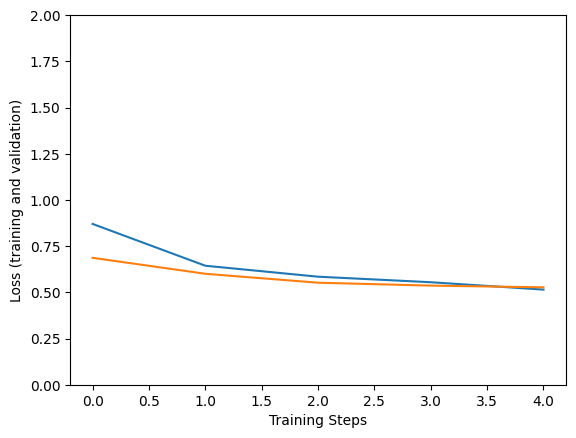

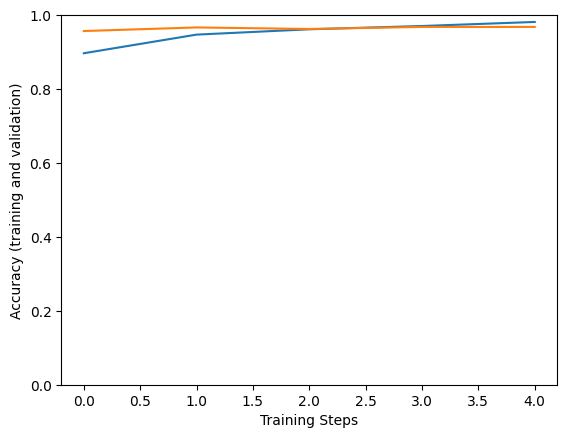

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

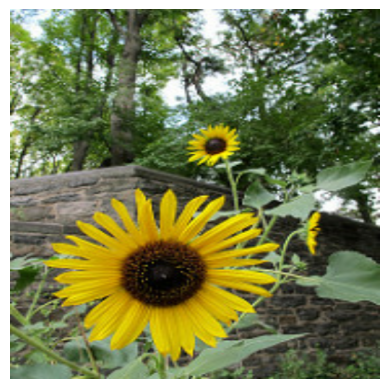

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 4s 4s/step


True label: sunflowers
Predicted label: sunflowers


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [12]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [13]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

2023-03-08 14:18:26.280656: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-03-08 14:18:26.280701: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


Wrote TFLite model of 826217856 bytes.


In [14]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [15]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 50 of 50 examples (100%).
